### 3.4 Dimensionality Reduction, Feature Extraction and Manifold Learning
- Principal Component Analysis (PCA)
  - 가장 간단하고 흔히 사용하는 대표적인 기법
- Non-negative matrix factorization (NMF)
  - 특성 추출에 널리 사용
- t-distributed stochastic neighbor embedding (t-SNE)
  - 2차원 산점도를 이용해 시각화 용도로 많이 활용

#### 3.4.1 Principal Component Analysis (PCA)

In [25]:
%matplotlib inline
import sys 
sys.path.append('..')
from preamble import *
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

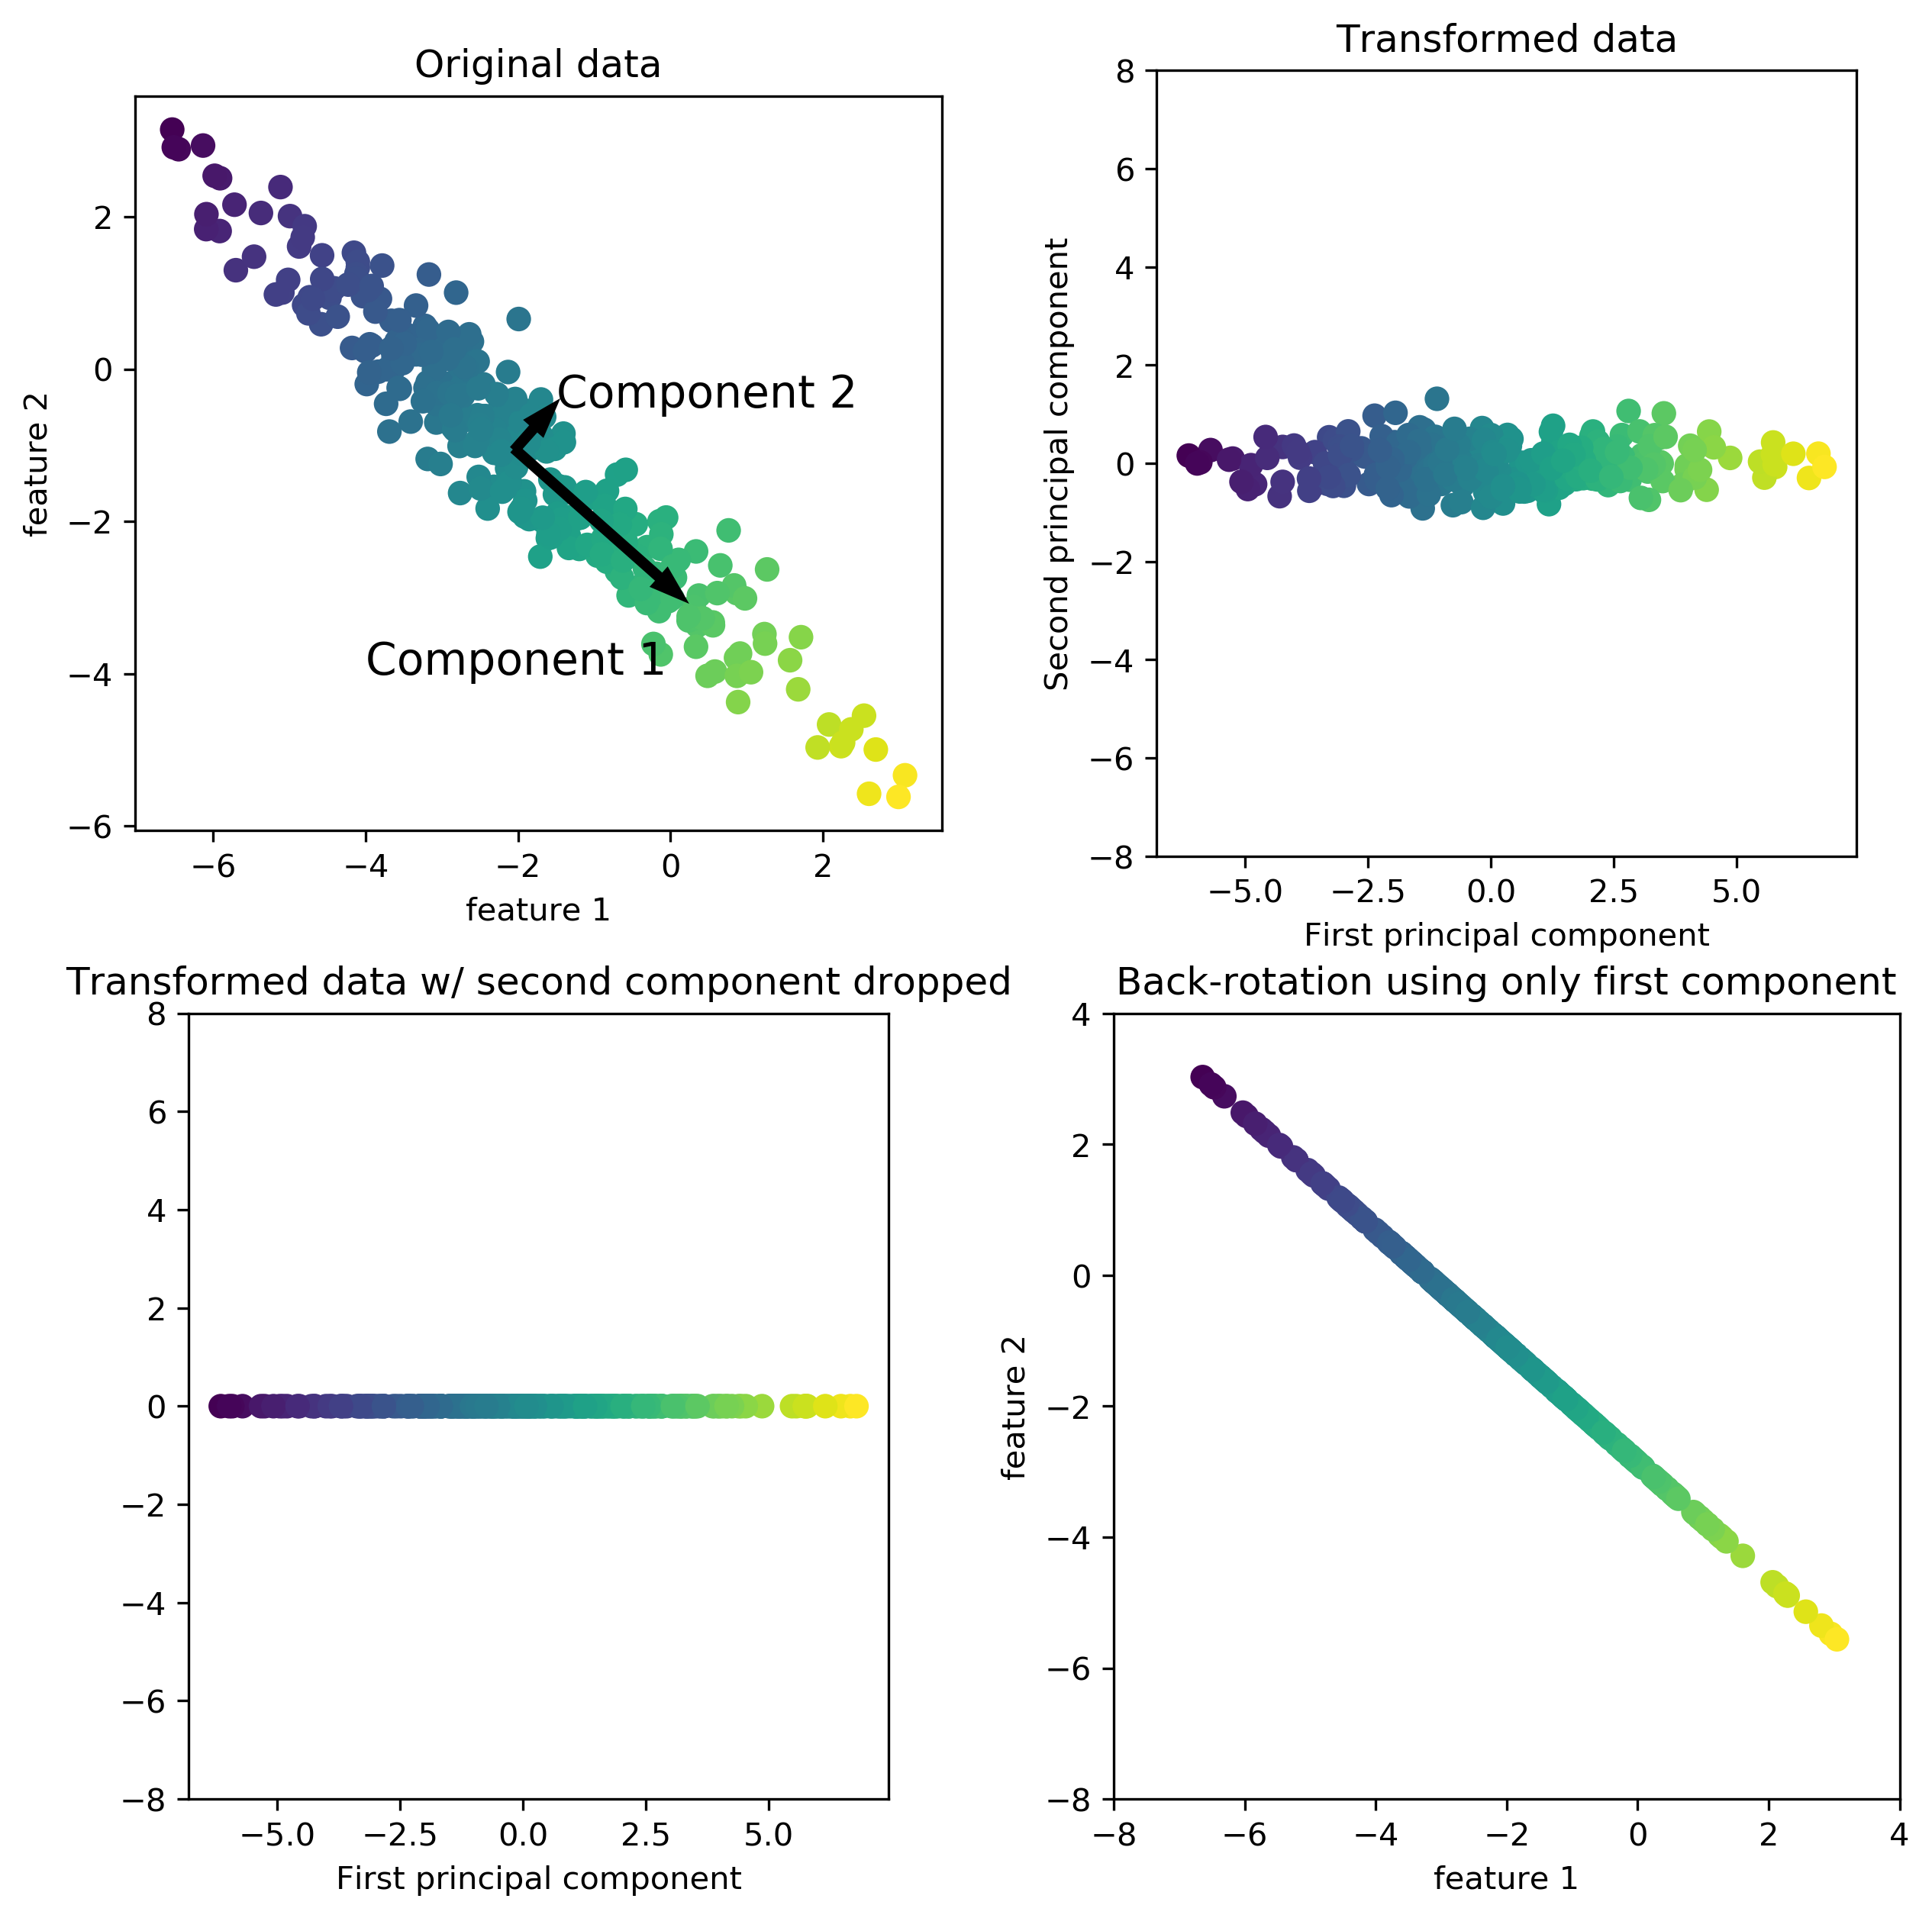

In [2]:
mglearn.plots.plot_pca_illustration()

##### Applying PCA to the cancer dataset for visualization
- 유방함 데이터의 특성값의 개수는 30개
- 30개의 특성들에 대한 산점도 그래프를 그리면 총 435개의 산점도가 산출됨
- 보다 더 쉽게 특성 데이터들을 시각화 하는 방법은 악성(Malignant)와 양성(Benign)에 대해 30개의 특성의 히스토그램을 그리는 것 

cancer.data.shape: (569, 30)


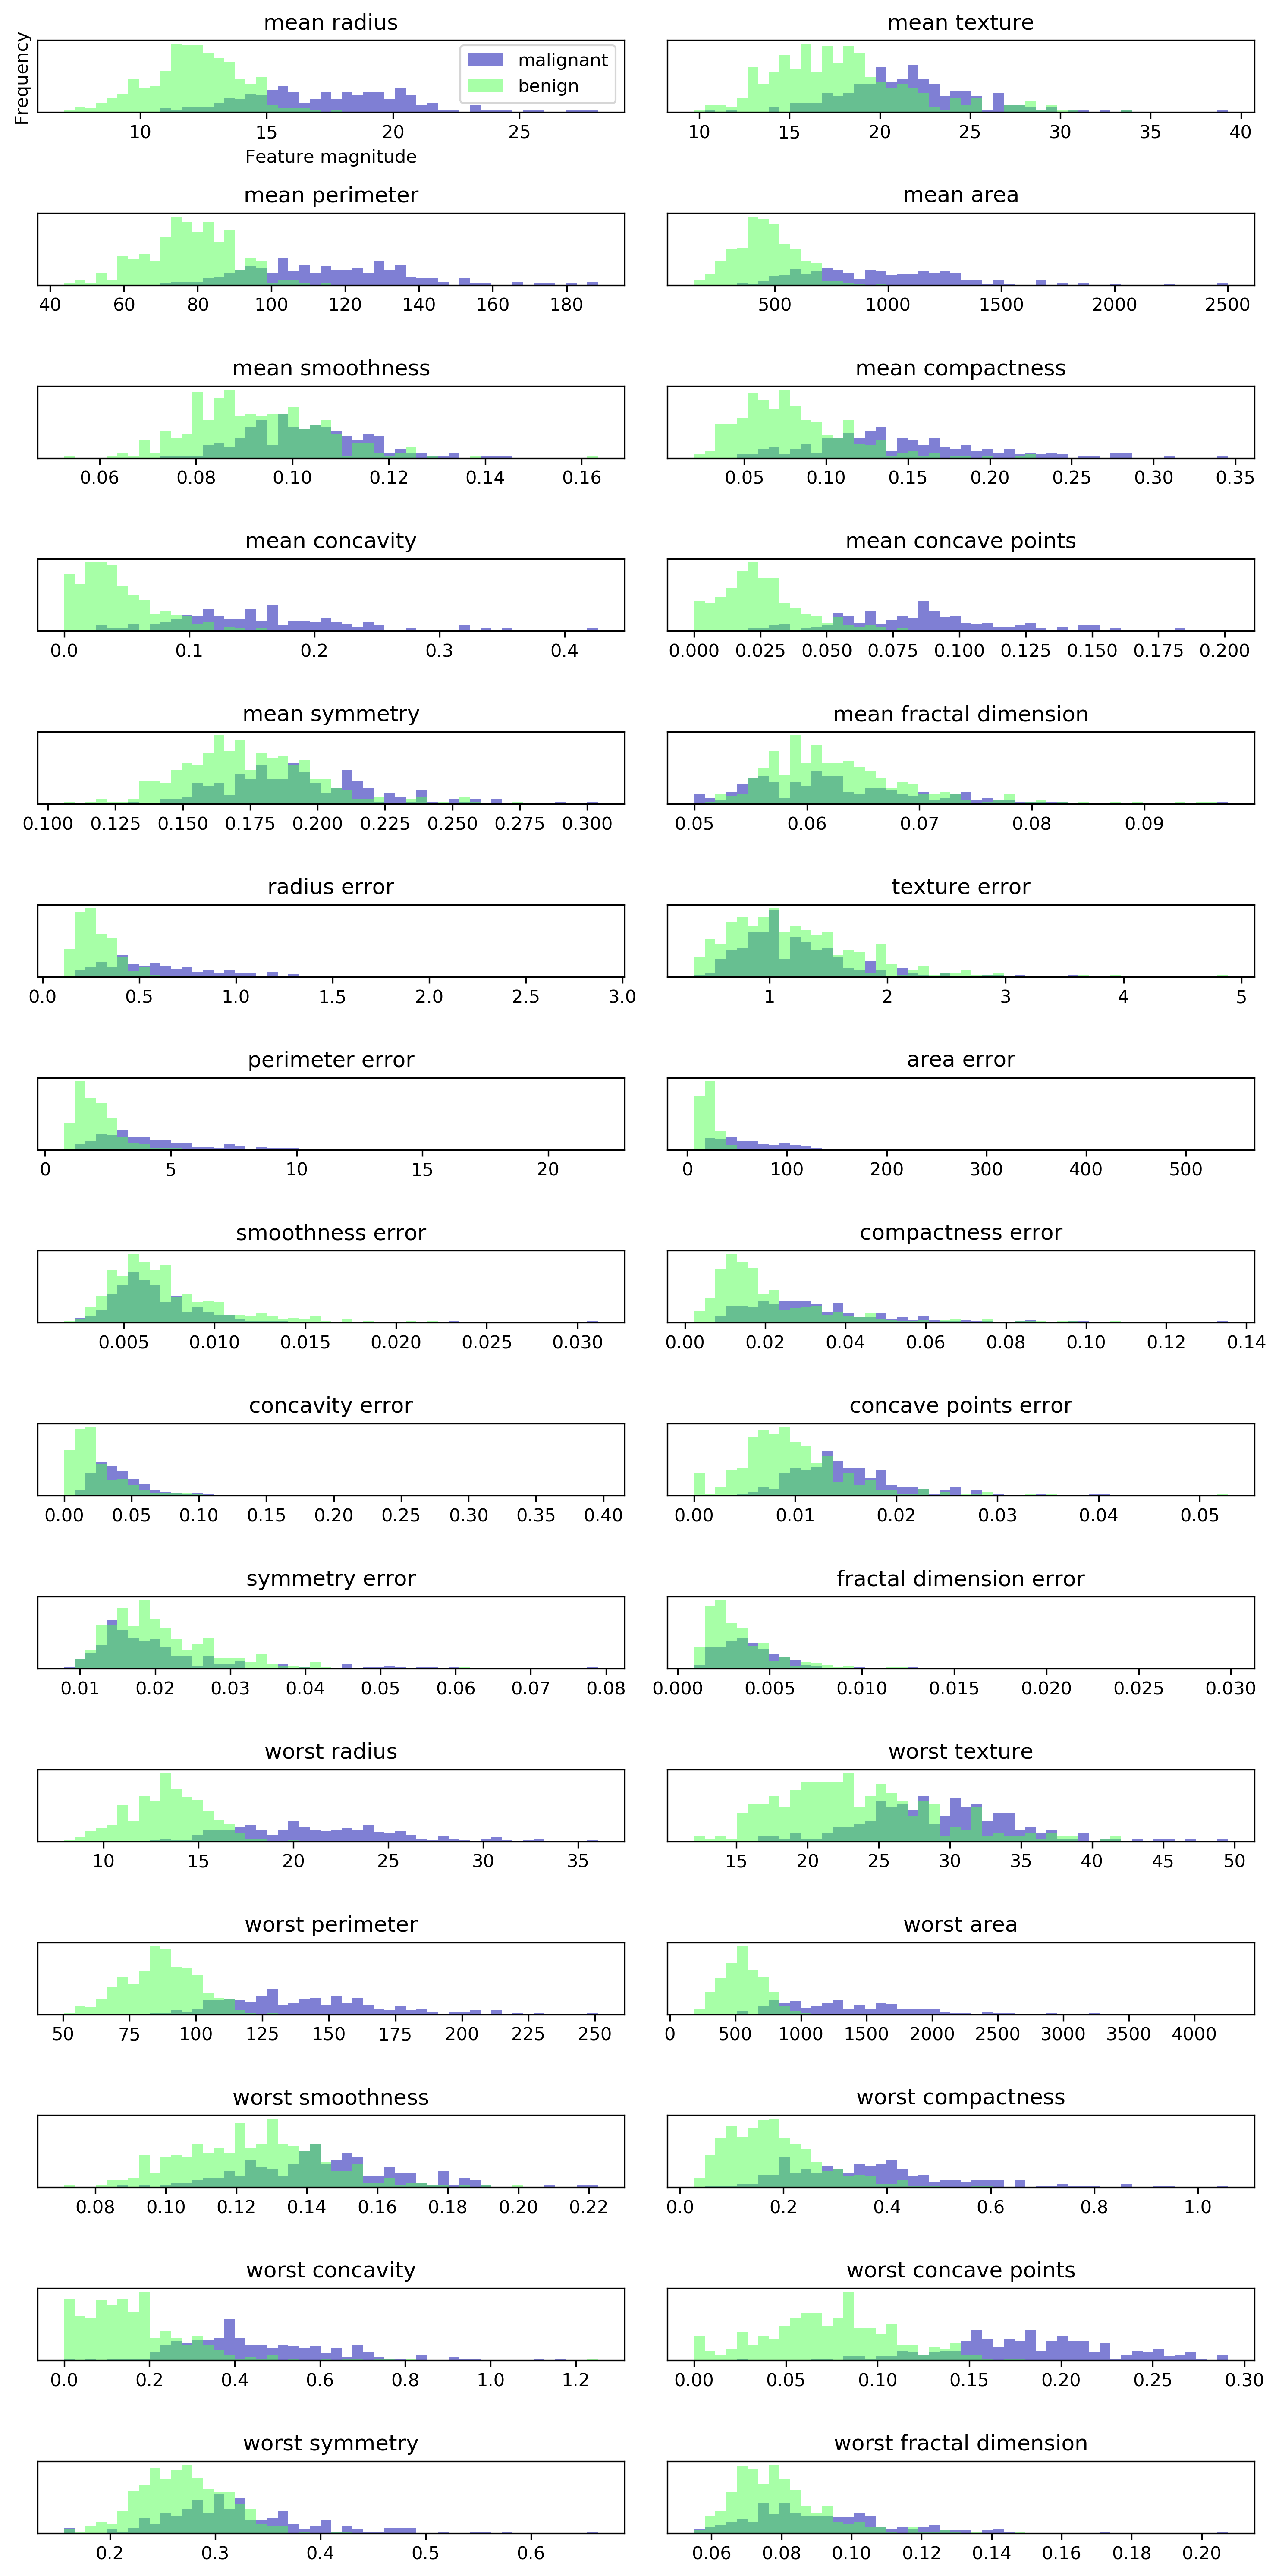

In [3]:
print("cancer.data.shape: {}".format(cancer.data.shape))

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

- 위 그래프에서 다음 두 개의 특성 주목
  - smoothness error: 두 히스토그램이 겹쳐서 별로 쓸모 없는 특성임
  - worst concave points: 두 히스토그램이 확실이 구분되어 매우 유용한 특성임

- PCA 적용전에 StandardScaler를 사용하여 각 특성의 분산이 1이 되도록 스케일링

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
scaler = StandardScaler()

scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)
print("X_scaled.shape: {}".format(X_scaled.shape))

X_scaled.shape: (569, 30)


- n_components: 차원 축소의 결과로 남게될 차원의 개수

In [5]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=2)
# fit PCA model to beast cancer data
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


Text(0,0.5,'Second principal component')

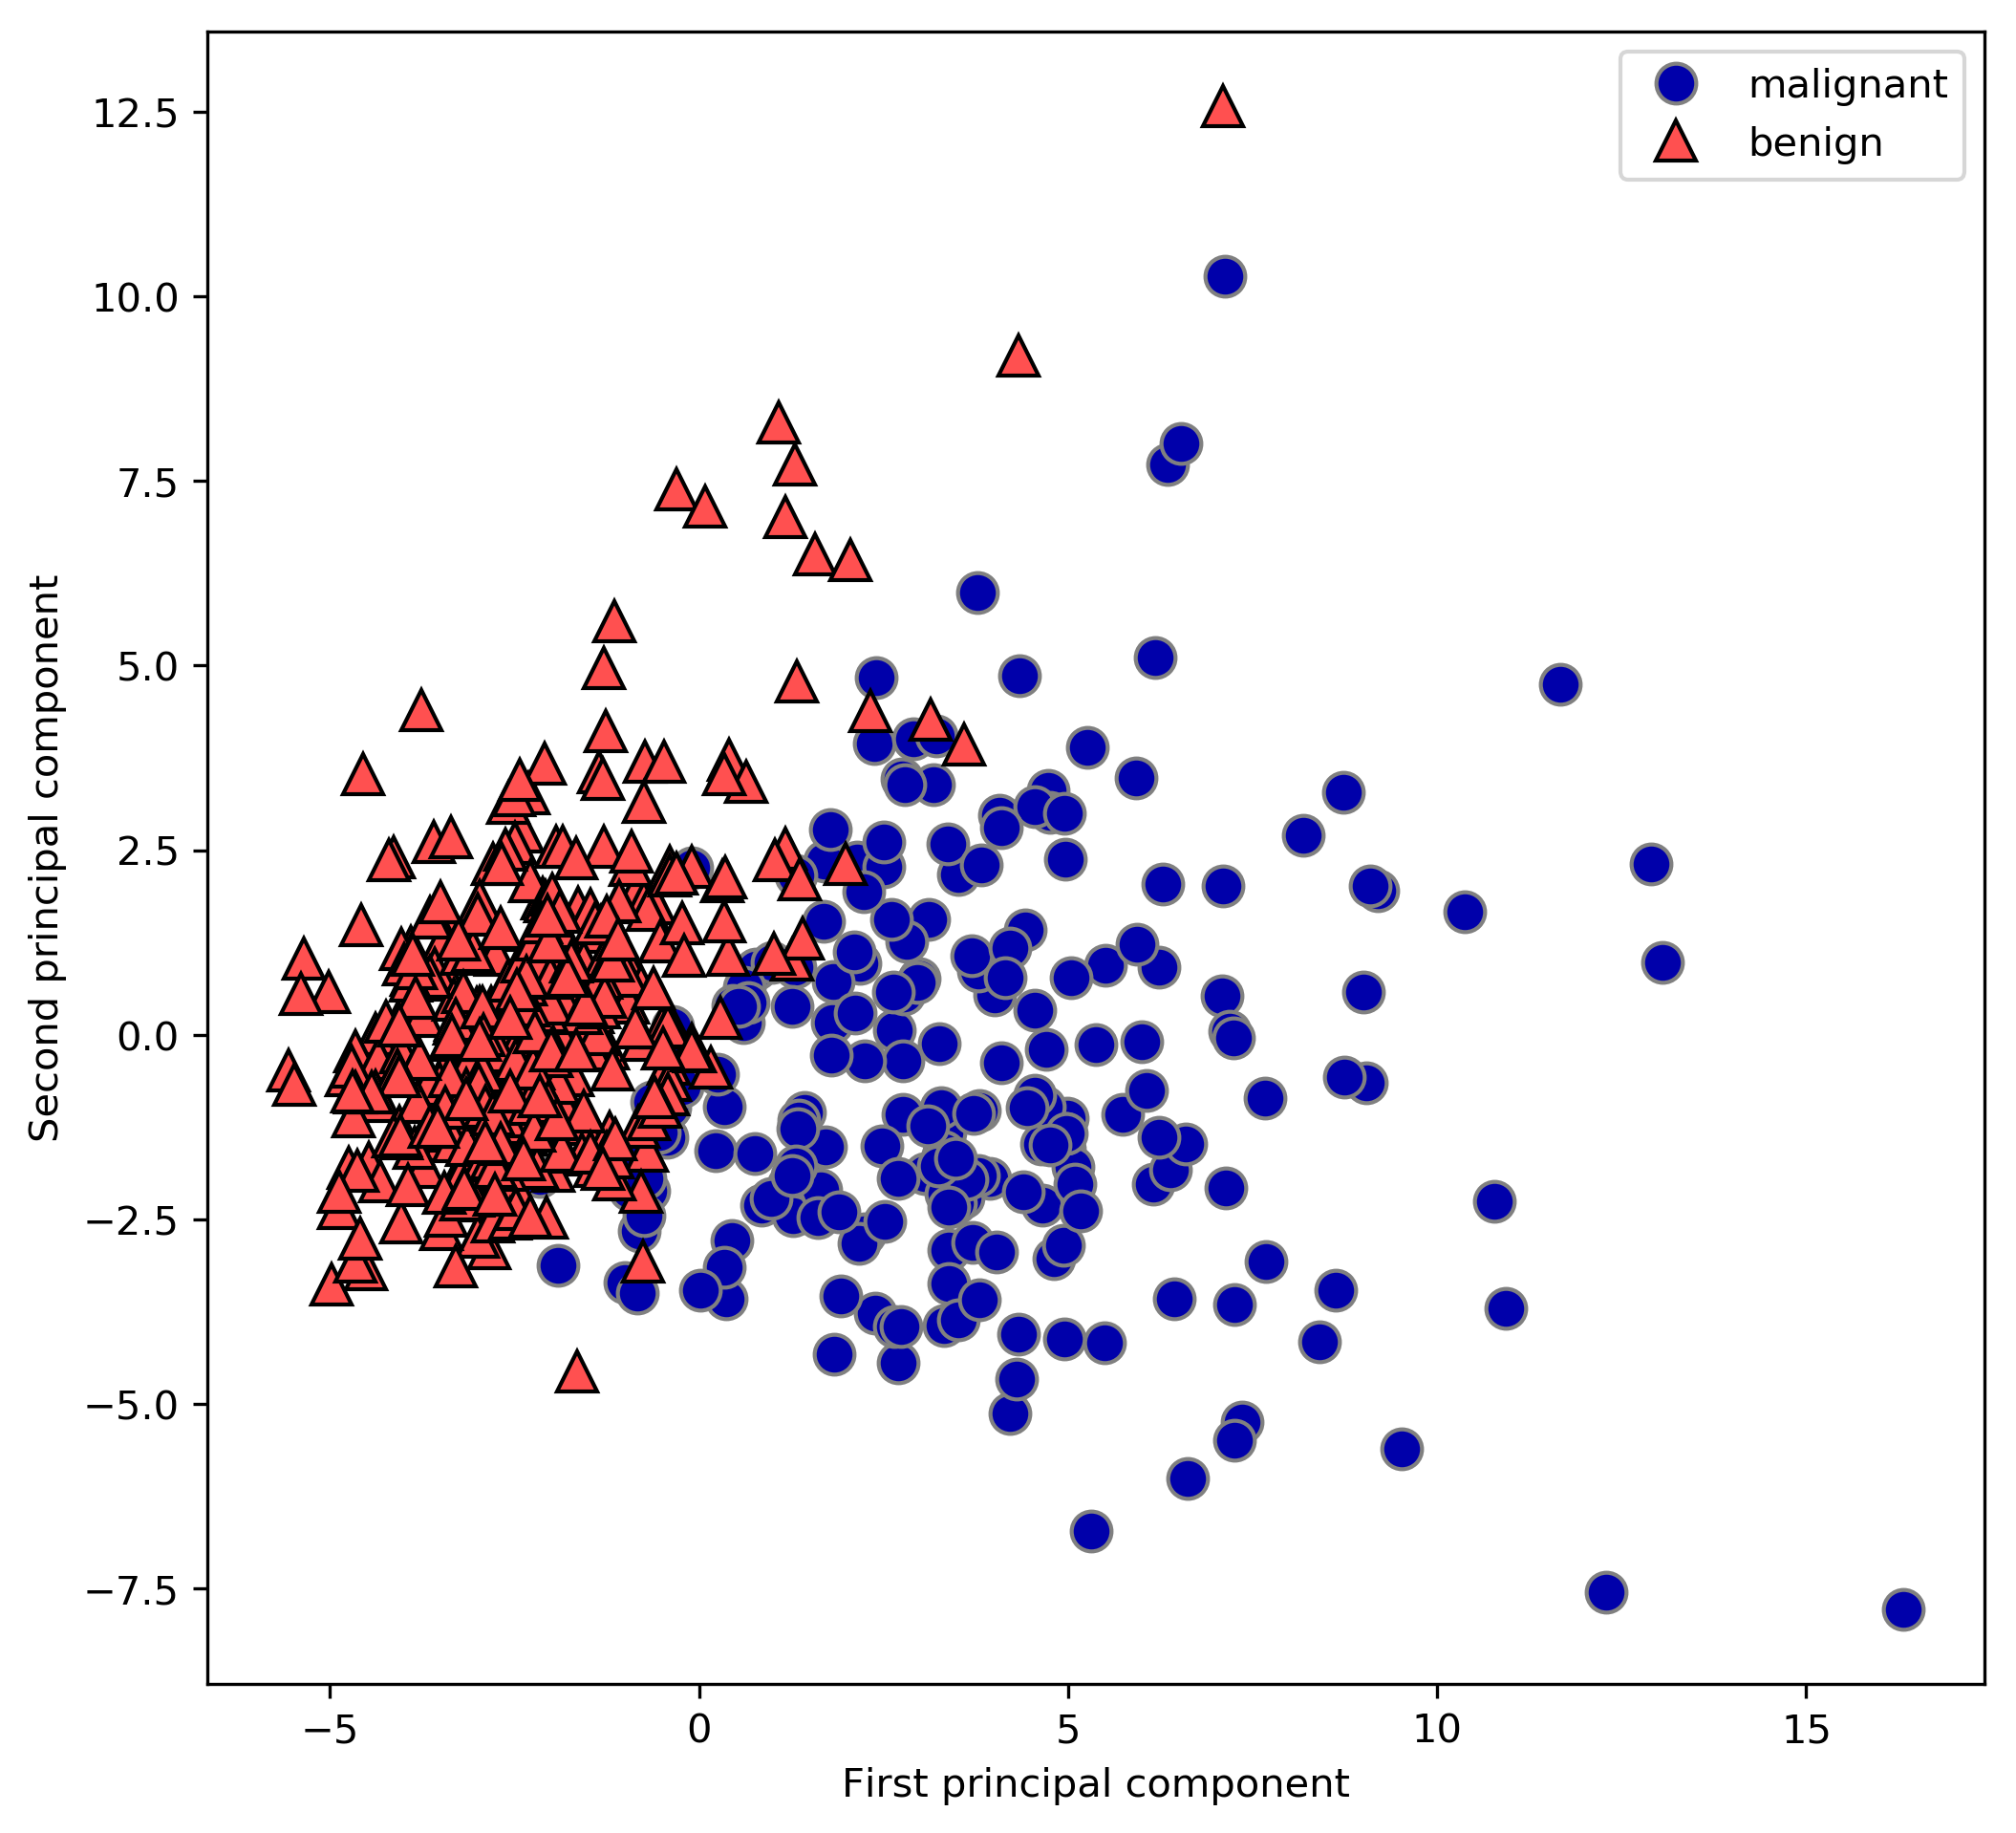

In [6]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

- 산출된 주성분은 원본 데이터에 있는 해당 주성분 방향에 대응하는 여러 특성이 조합된 형태
- components_  변수
  - 주성분의 구성 모습이 담겨 있음

In [7]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


In [8]:
print("PCA components:\n{}".format(pca.components_))

PCA components:
[[ 0.219  0.104  0.228  0.221  0.143  0.239  0.258  0.261  0.138  0.064
   0.206  0.017  0.211  0.203  0.015  0.17   0.154  0.183  0.042  0.103
   0.228  0.104  0.237  0.225  0.128  0.21   0.229  0.251  0.123  0.132]
 [-0.234 -0.06  -0.215 -0.231  0.186  0.152  0.06  -0.035  0.19   0.367
  -0.106  0.09  -0.089 -0.152  0.204  0.233  0.197  0.13   0.184  0.28
  -0.22  -0.045 -0.2   -0.219  0.172  0.144  0.098 -0.008  0.142  0.275]]


Text(0,0.5,'Principal components')

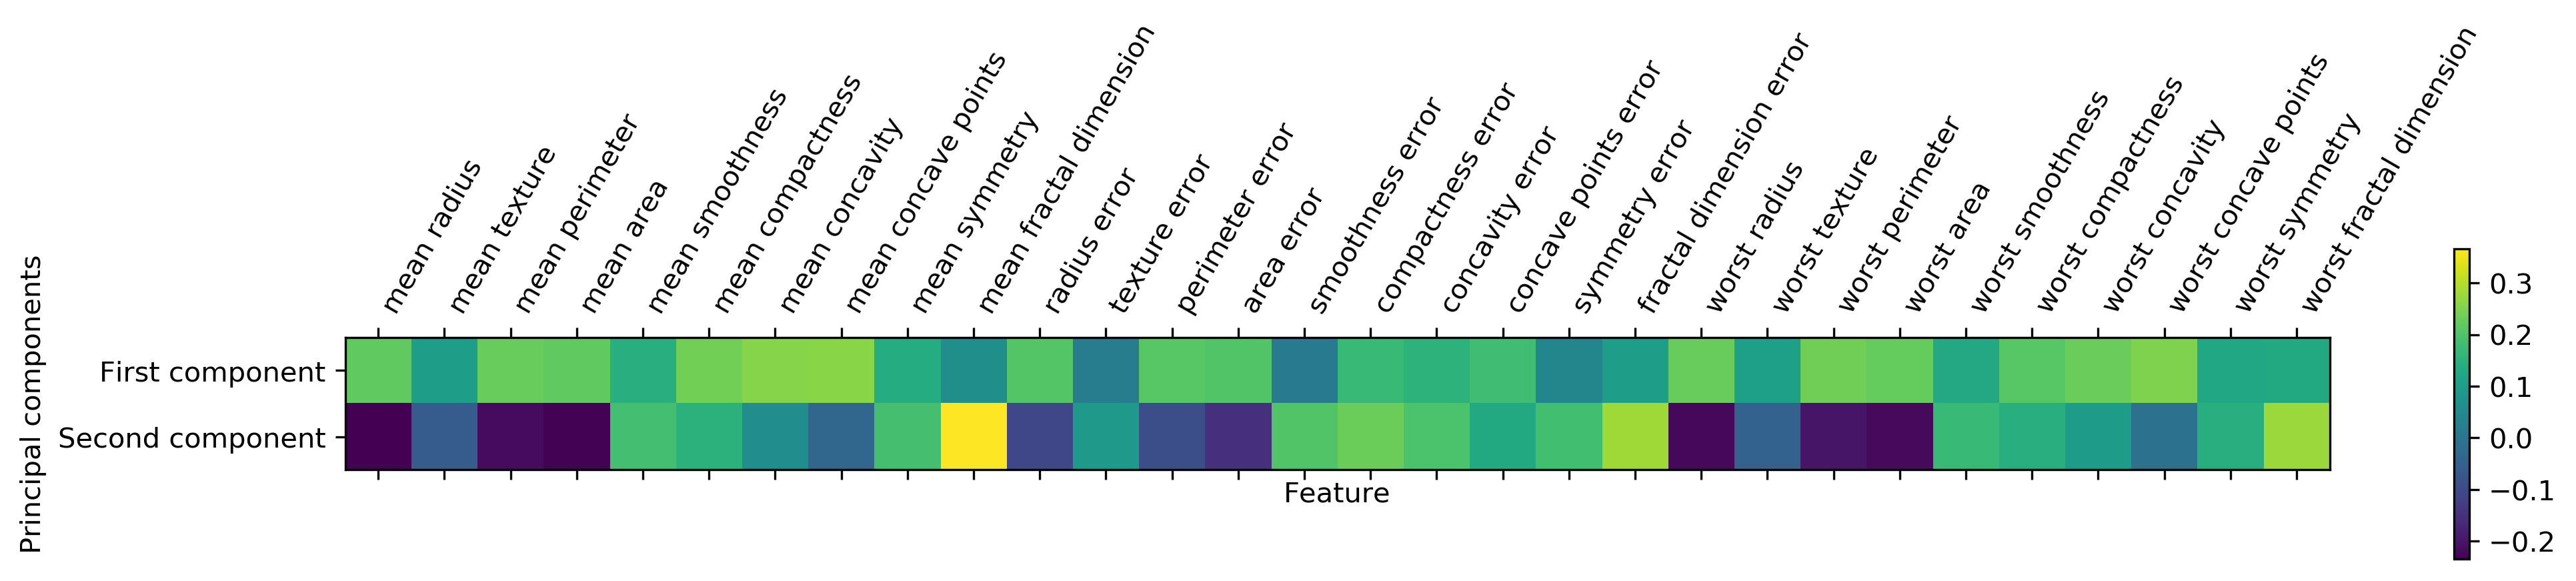

In [9]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

##### Eigenfaces for feature extraction
- PCA를 사용한 특성 추출
  - 원본 데이터 표현보다 분석하기에 더 적합한 데이터 표현을 찾을 수 있으리라는 생각에서 출발<br/><br/>

- 얼굴 이미지에서 주요 특성 추출하는 응용 제작
  - LFW (Labled Faces in the Wild) 데이터셋 활용
    - 인터넷에서 Crawling한 유명 인사(2000년 초반 이후의 정치인, 가수, 배우, 운동선수)들의 얼굴 이미지
    - 처리 속도를 높이기 위해 흑백 이미지를 사용하고 스케일을 줄임
      - fetch_lfw_people 함수 사용
      - 인자
        - color=False (기본값)
          - color가 True이면 3 RGB channels 값 유지          
        - resize=0.5 (기본값)
        - min_faces_per_person=None (기본값)
          - 각 사람 얼굴당 최소한의 이미지 개수를 지정
    - 출처: 메사추세츠 애머스트 주립대학의 Vision Lab (http://vis-www.cs.umass.edu/lfw/)

In [11]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

print("people.images.shape: {}".format(people.images.shape))
print("An image shape: {}".format(people.images[0].shape))
print("Number of classes: {}".format(len(people.target_names)))
print()
print("people.data.shape: {}".format(people.data.shape))
print("people.target.shape: {}".format(people.target.shape))

/Users/jubong/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/jubong/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


people.images.shape: (2769, 87, 65)
An image shape: (87, 65)
Number of classes: 53

people.data.shape: (2769, 5655)
people.target.shape: (2769,)


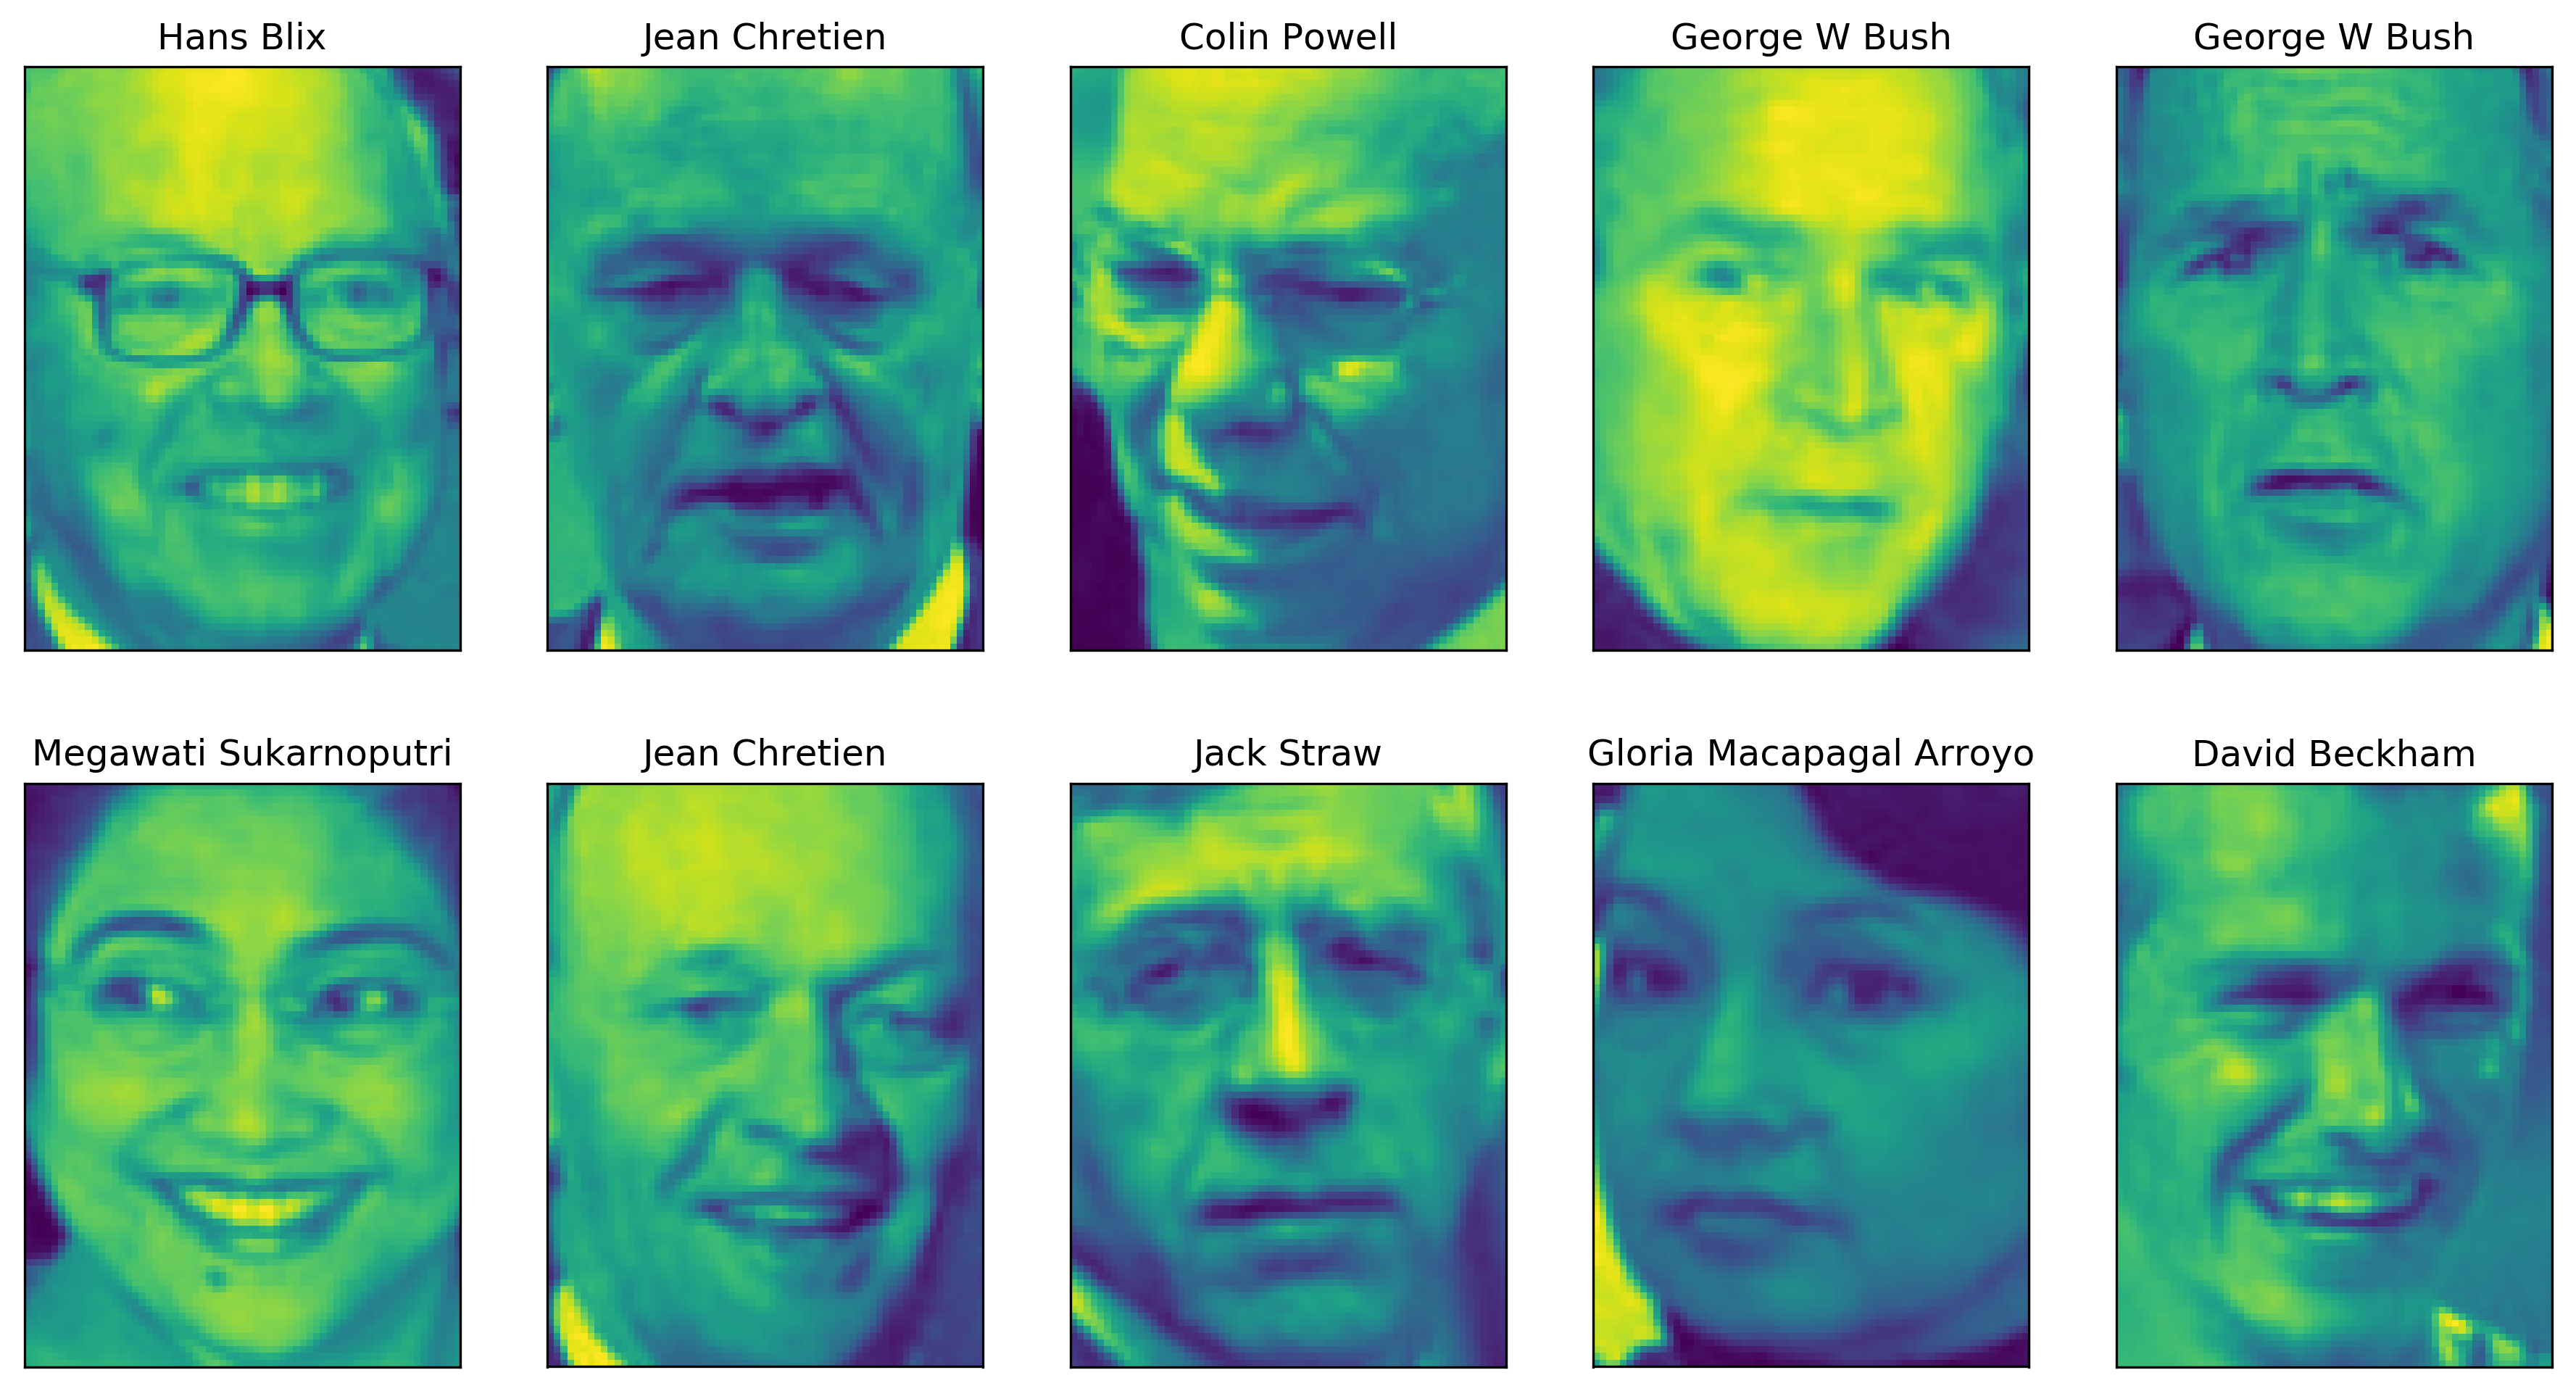

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

- George W Bush (530)와 Colin Powell (236)의 이미지가 많음

In [13]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("[{0:2}] {1:23} {2:3}".format(i, name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

[ 0] Alejandro Toledo         39   [ 1] Alvaro Uribe             35   [ 2] Amelie Mauresmo          21   
[ 3] Andre Agassi             36   [ 4] Ariel Sharon             77   [ 5] Arnold Schwarzenegger    42   
[ 6] Atal Bihari Vajpayee     24   [ 7] Bill Clinton             29   [ 8] Carlos Menem             21   
[ 9] Colin Powell            236   [10] David Beckham            31   [11] Donald Rumsfeld         121   
[12] George Robertson         22   [13] George W Bush           530   [14] Gerhard Schroeder       109   
[15] Gloria Macapagal Arroyo  44   [16] Gray Davis               26   [17] Hamid Karzai             22   
[18] Hans Blix                39   [19] Hugo Chavez              71   [20] Igor Ivanov              20   
[21] Jack Straw               28   [22] Jacques Chirac           52   [23] Jean Chretien            55   
[24] Jennifer Aniston         21   [25] Jennifer Capriati        42   [26] Jennifer Lopez           21   
[27] Jeremy Greenstock        24   [28] Jiang 

In [14]:
print("people.target.shape:", people.target.shape)
print()
mask = np.zeros(people.target.shape, dtype=np.bool)

print("mask.shape:", mask.shape)
print()

print("np.unique(people.target):\n{0}".format(np.unique(people.target)))
print()

for target in np.unique(people.target):
    print("np.where(people.target == {0}):\n{1}".format(target, np.where(people.target == target)))
    mask[np.where(people.target == target)[0][:50]] = 1
    print()
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

people.target.shape: (2769,)

mask.shape: (2769,)

np.unique(people.target):
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]

np.where(people.target == 0):
(array([  66,   90,  262,  684,  790,  848, 1019, 1050, 1068, 1147, 1265,
       1334, 1365, 1499, 1518, 1577, 1636, 1646, 1760, 1766, 1785, 1900,
       1919, 1949, 1954, 2002, 2013, 2051, 2169, 2235, 2300, 2324, 2405,
       2428, 2430, 2470, 2588, 2714, 2746]),)

np.where(people.target == 1):
(array([  68,  110,  148,  186,  191,  236,  244,  271,  409,  610,  622,
        668,  672,  676,  816,  945, 1106, 1271, 1290, 1299, 1448, 1510,
       1537, 1620, 2010, 2055, 2066, 2080, 2094, 2097, 2158, 2183, 2399,
       2417, 2682]),)

np.where(people.target == 2):
(array([ 128,  157,  272,  648,  761, 1144, 1168, 1242, 1567, 1614, 1774,
       1848, 1855, 1950, 2021, 2083, 2142, 2208, 2238, 2284, 2320]),)

np.where(peopl

[얼굴 분류 문제의 어려운점]
- Supervised Learning
- 일반적으로 얼굴 데이터베이스에는 사람의 수는 매우 많지만 각 사람에 대한 이미지 수는 적음 (즉, 클래스별 훈련 데이터가 작음)
- 대규모 모델을 처음부터 다시 훈련시키지 않고도 새로운 사람의 얼굴을 쉽게 추가하여 모델을 강화시킬 수 있어야 함
- KNeighborsClassifier
  - 위와 같은 문제가 존재할 때 가장 쉽게 사용할 수 있는 모델
  - n_neighbors=1
    - 클래스마다 하나의 최근접 훈련 샘플만 사용

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# split the data in training and test set
# stratify parameter makes a split so that the proportion of values in the sample produced 
# will be the same as the proportion of values provided to parameter stratify.
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
print("X_train.shape: {}".format(X_train.shape))
print("y_train.shape: {}".format(y_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_test.shape: {}".format(y_test.shape))

# build a KNeighborsClassifier with using one neighbor:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

X_train.shape: (1356, 5655)
y_train.shape: (1356,)
X_test.shape: (453, 5655)
y_test.shape: (453,)
Test set score of 1-nn: 0.27


- 0.23의 분류 정확도
  - 좋은 결과 아님
  - 두 이미지의 동일 위치 픽셀의 거리 비교 기반 --> 실제적으로 얼굴이미지를 인식하는 것과 다름
  - 동일한 두 사람 얼굴에 대해 얼굴위치가 한 픽셀만 오른쪽으로 이동해도 전혀 다른 얼굴 이미지로 인식 

- PCA with Whitening (백색화)
  - 인자: whiten=True
  - 일반적인 PCA 결과 데이터에 대하여 StandardScaler 적용
  - 즉, PCA 변환 결과 데이터 특성들이 평균이 0, 표준편차가 1이 되도록 변환

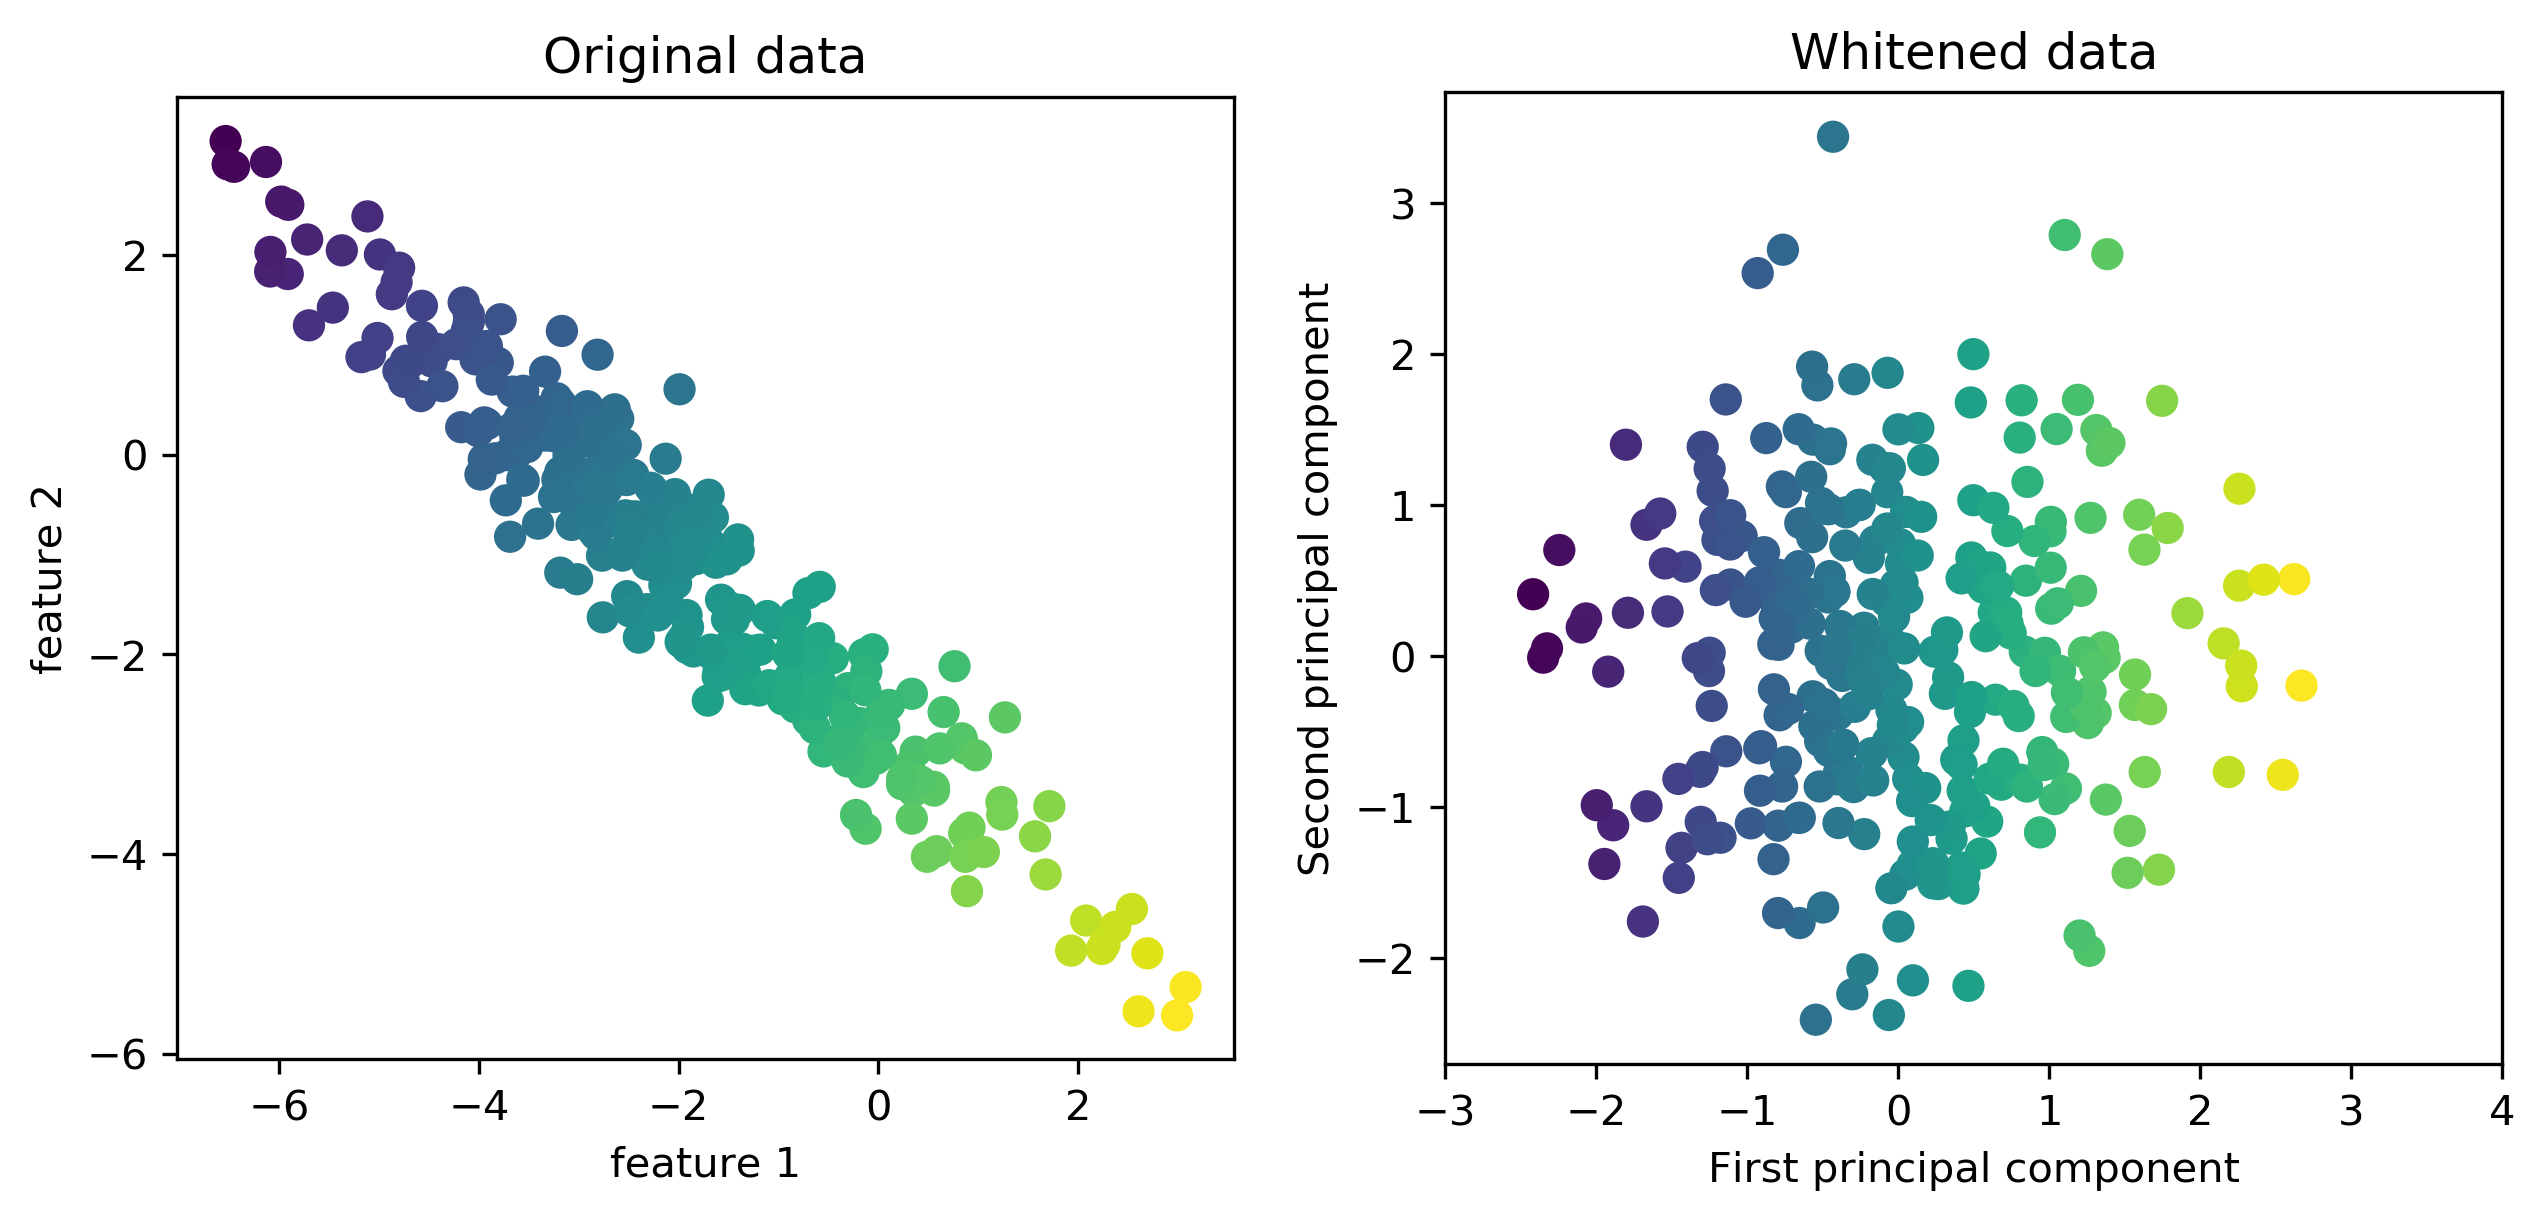

In [16]:
mglearn.plots.plot_pca_whitening()

In [17]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1356, 100)


In [18]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.35


- PCA 모델을 활용한 정확도가 0.23 에서 0.31로 향상됨

In [19]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


- 이미지인 경우 주성분 시각화 가능

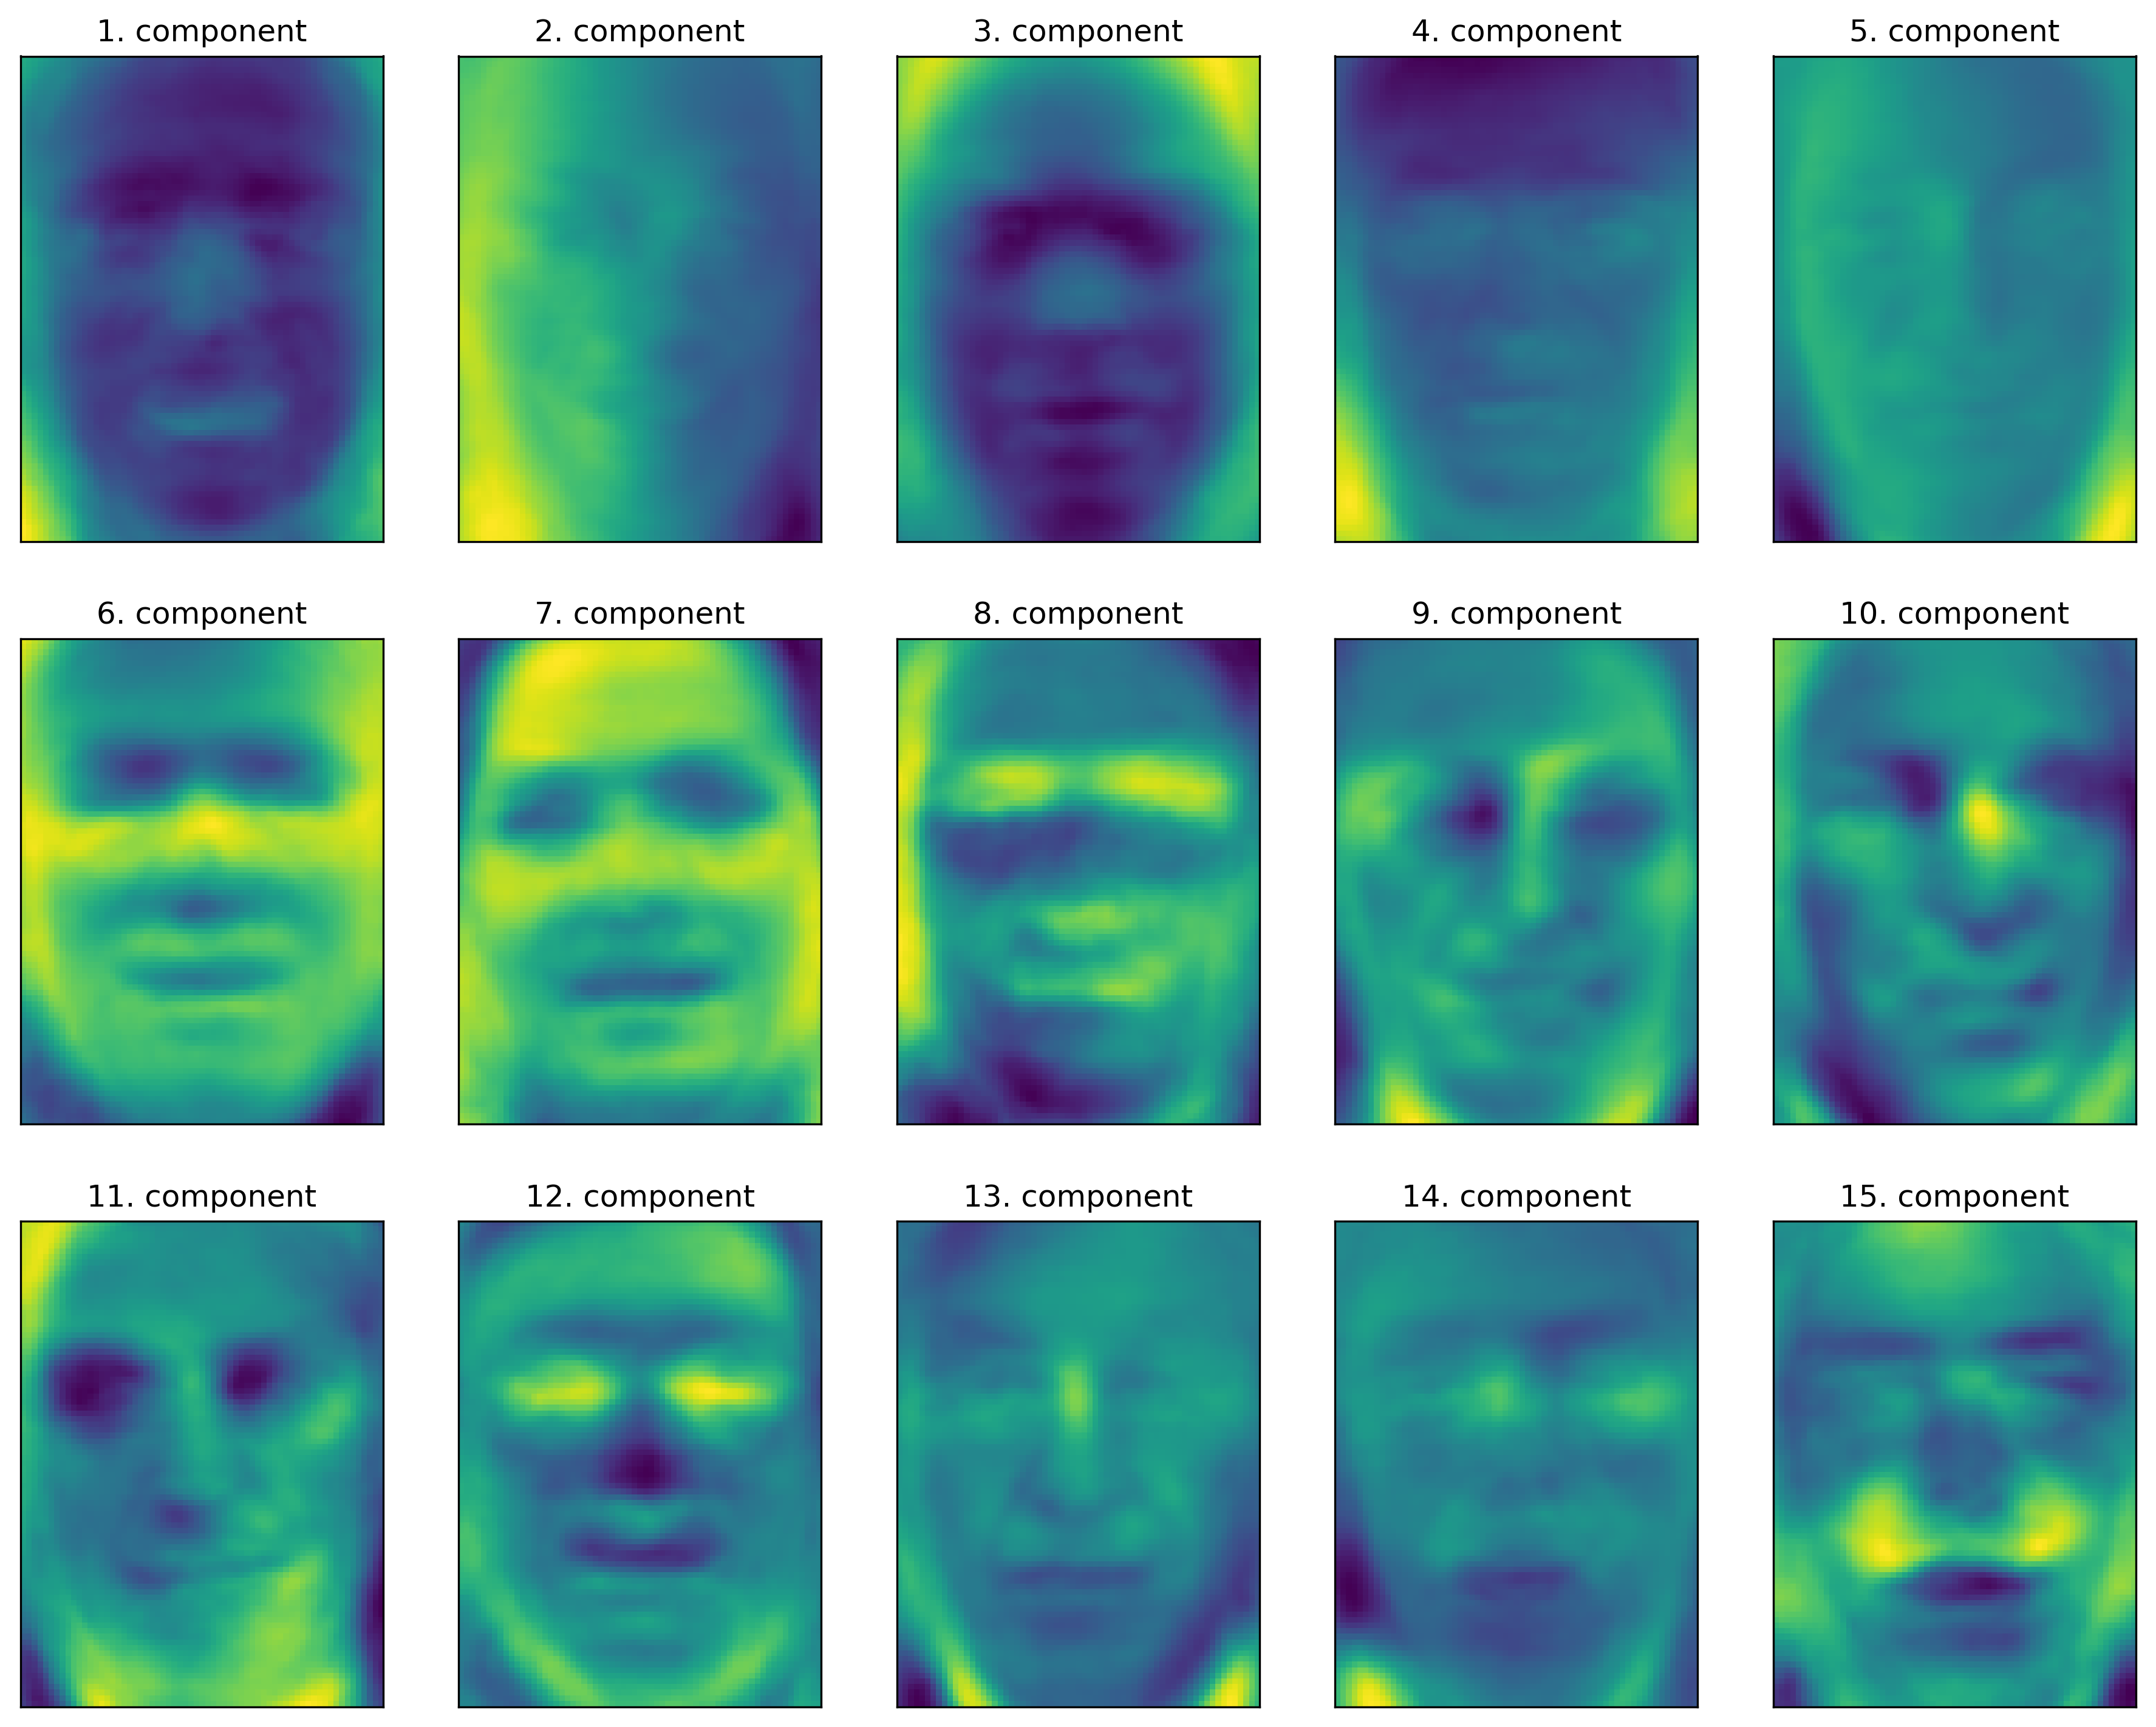

In [20]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

In [37]:
# FIXME hide this!
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

image_shape = people.images[0].shape
plt.figure(figsize=(20, 3))
ax = plt.gca()

imagebox = OffsetImage(people.images[0], zoom=7, cmap="gray")
ab = AnnotationBbox(imagebox, (.05, 0.4), pad=0.0, xycoords='data')
ax.add_artist(ab)

for i in range(4):
    imagebox = OffsetImage(pca.components_[i].reshape(image_shape), zoom=7,
                           cmap="viridis")

    ab = AnnotationBbox(imagebox, (.3 + .2 * i, 0.4),
                        pad=0.0,
                        xycoords='data'
                        )
    ax.add_artist(ab)
    if i == 0:
        plt.text(.18, .25, 'x_{} *'.format(i), fontdict={'fontsize': 50})
    else:
        plt.text(.15 + .2 * i, .25, '+ x_{} *'.format(i),
                 fontdict={'fontsize': 50})

plt.text(.95, .25, '+ ...', fontdict={'fontsize': 50})

plt.text(.13, .3, r'\approx', fontdict={'fontsize': 50})
plt.axis("off")
plt.savefig("../images/03-face_decomposition.png")
plt.close()

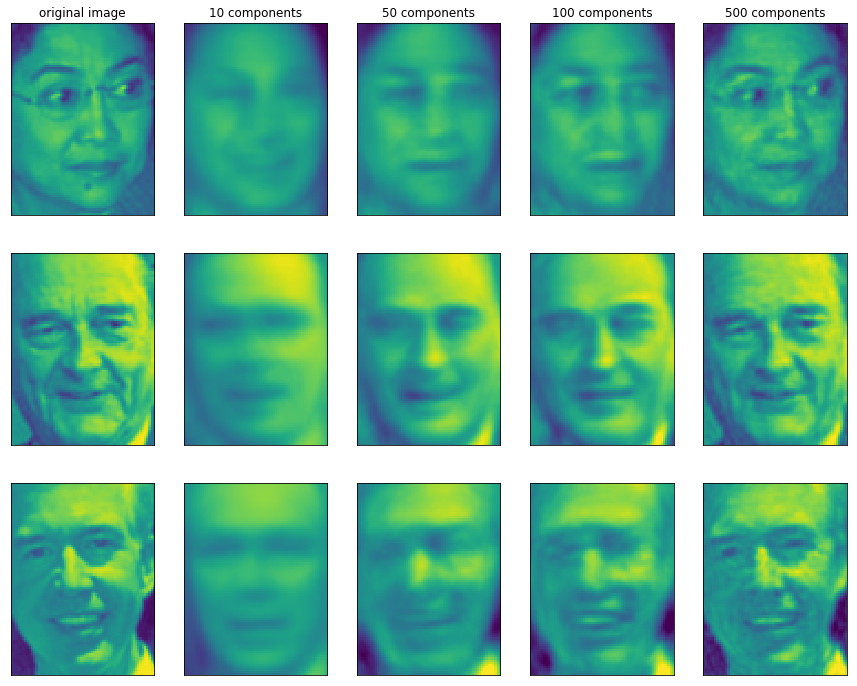

In [38]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

Text(0,0.5,'Second principal component')

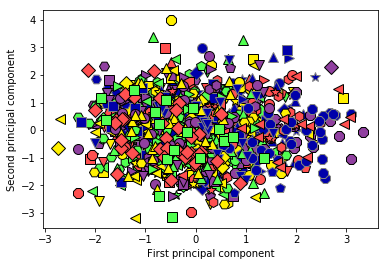

In [39]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")